## Configurations for Colab

In [11]:
from copy import deepcopy
from explicit_memory.memory import EpisodicMemory, SemanticMemory, ShortMemory
from explicit_memory.agent.policy import (
    answer_question,
    encode_observation,
    manage_memory,
)


In [12]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium == 0.28.1
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 01. DQN

[V. Mnih et al., "Human-level control through deep reinforcement learning." Nature, 518
(7540):529–533, 2015.](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as $Q$) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to $Q$ may significantly change the policy and therefore change the data distribution, and the correlations between the action-values ($Q$) and the target values $r + \gamma \max_{a'} Q(s', a')$.

The authors suggest two key ideas to address these instabilities with a novel variant of Q-learning: Replay buffer and Fixed Q-target.

#### Uniformly random sampling from Experience Replay Memory

Reinforcement learning agent stores the experiences consecutively in the buffer, so adjacent ($s, a, r, s'$) transitions stored are highly likely to have correlation. To remove this, the agent samples experiences uniformly at random from the pool of stored samples $\big( (s, a, r, s') \sim U(D) \big)$. See sample_batch method of ReplayBuffer class for more details.

#### Fixed Q-target

DQN uses an iterative update that adjusts the action-values ($Q$) towards target values that are only periodically updated, thereby reducing correlations with the target; if not, it is easily divergy because the target continuously moves. The Q-learning update at iteration $i$ uses the following loss function:

$$
L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)} \big[ \big( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s, a; \theta_i) \big)^2 \big]
$$

in which $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the Q-network at iteration $i$ and $\theta_i^-$ are the network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^-$ are only updated with the Q-network parameters ($\theta_i$) every C steps and are held fixed between individual updates. ($C = 200$ in CartPole-v0)

#### For more stability: Gradient clipping

The authors also found it helpful to clip the error term from the update $r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s,a,;\theta_i)$ to be between -1 and 1. Because the absolute value loss function $|x|$ has a derivative of -1 for all negative values of x and a derivative of 1 for all positive values of x, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

In [13]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output


## Replay buffer

Typically, people implement replay buffers with one of the following three data structures:

  - collections.deque
  - list
  - numpy.ndarray
  
**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of  *Get item* is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference). Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.


Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

In [20]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, size: int, batch_size: int = 32):
        self.obs_buf = np.array(["foo"] * size)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        (
            self.ptr,
            self.size,
        ) = (
            0,
            0,
        )

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size


foo = ReplayBuffer()


TypeError: __init__() missing 2 required positional arguments: 'obs_dim' and 'size'

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [15]:
# class Network(nn.Module):
#     def __init__(self, in_dim: int, out_dim: int):
#         """Initialization."""
#         super(Network, self).__init__()

#         self.layers = nn.Sequential(
#             nn.Linear(in_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, out_dim),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """Forward method implementation."""
#         return self.layers(x)

"""Deep Q-network architecture. Currently only LSTM is implemented."""
import ast
from copy import deepcopy

import torch
from torch import nn


class Network(nn.Module):
    """A simple LSTM network."""

    def __init__(
        self,
        hidden_size: int,
        num_layers: int,
        n_actions: int,
        embedding_dim: int,
        capacity: dict,
        entities: dict,
        include_human: str,
        batch_first: bool = True,
        memory_systems: list = ["episodic", "semantic", "short"],
        human_embedding_on_object_location: bool = False,
        accelerator: str = "cpu",
        **kwargs,
    ) -> None:
        """Initialize the LSTM.

        Args
        ----
        hidden_size: hidden size of the LSTM
        num_layers: number of the LSTM layers
        n_actions: number of actions. This should be 3, at the moment.
        embedding_dim: entity embedding dimension (e.g., 32)
        capacity: the capacities of memory systems.
            e.g., {"episodic": 16, "semantic": 16, "short": 1}
        entities:
            e,g, {
            "humans": ["Foo", "Bar"],
            "objects": ["laptop", "phone"],
            "object_locations": ["desk", "lap"]}
        include_human:
            None: Don't include humans
            "sum": sum up the human embeddings with object / object_location embeddings.
            "cocnat": concatenate the human embeddings to object / object_location
                embeddings.
        batch_first: Should the batch dimension be the first or not.
        memory_systems: memory systems to be included as input
        human_embedding_on_object_location: whether to superposition the human embedding
            on the tail (object location entity).
        accelerator: "cpu", "gpu", or "auto"

        """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.capacity = capacity
        self.entities = entities
        self.include_human = include_human
        self.memory_systems = [ms.lower() for ms in set(memory_systems)]
        self.human_embedding_on_object_location = human_embedding_on_object_location

        if accelerator == "gpu":
            self.device = "cuda"
        elif accelerator == "cpu":
            self.device = "cpu"
        else:
            raise ValueError

        self.create_embeddings()
        if "episodic" in self.memory_systems:
            self.lstm_e = nn.LSTM(
                self.input_size_e, hidden_size, num_layers, batch_first=batch_first
            )
            self.fc_e0 = nn.Linear(hidden_size, hidden_size)
            self.fc_e1 = nn.Linear(hidden_size, hidden_size)

        if "semantic" in self.memory_systems:
            self.lstm_s = nn.LSTM(
                self.input_size_s, hidden_size, num_layers, batch_first=batch_first
            )
            self.fc_s0 = nn.Linear(hidden_size, hidden_size)
            self.fc_s1 = nn.Linear(hidden_size, hidden_size)

        if "short" in self.memory_systems:
            self.lstm_o = nn.LSTM(
                self.input_size_o, hidden_size, num_layers, batch_first=batch_first
            )
            self.fc_o0 = nn.Linear(hidden_size, hidden_size)
            # self.fc_o0 = nn.Linear(self.input_size_o, hidden_size)
            self.fc_o1 = nn.Linear(hidden_size, hidden_size)

        self.fc_final0 = nn.Linear(
            hidden_size * len(self.memory_systems),
            hidden_size * len(self.memory_systems),
        )
        self.fc_final1 = nn.Linear(hidden_size * len(self.memory_systems), n_actions)
        self.relu = nn.ReLU()

    def create_embeddings(self) -> None:
        """Create learnable embeddings."""
        self.word2idx = (
            ["<PAD>"]
            + self.entities["humans"]
            + self.entities["objects"]
            + self.entities["object_locations"]
        )
        self.word2idx = {word: idx for idx, word in enumerate(self.word2idx)}
        self.embeddings = nn.Embedding(
            len(self.word2idx), self.embedding_dim, device=self.device, padding_idx=0
        )
        self.input_size_s = self.embedding_dim * 2

        if (self.include_human is None) or (self.include_human.lower() == "sum"):
            self.input_size_e = self.embedding_dim * 2
            self.input_size_o = self.embedding_dim * 2

        elif self.include_human.lower() == "concat":
            self.input_size_e = self.embedding_dim * 3
            self.input_size_o = self.embedding_dim * 3
        else:
            raise ValueError(
                "include_human should be one of None, 'sum', or 'concat', "
                f"but {self.include_human} was given!"
            )

    def make_embedding(self, mem: dict, memory_type: str) -> torch.Tensor:
        """Create one embedding vector with summation and concatenation.

        Args
        ----
        mem: memory
            e.g, {"human": "Bob", "object": "laptop",
                  "object_location": "desk", "timestamp": 1}
        memory_type: "episodic", "semantic", or "short"

        Returns
        -------
        one embedding vector made from one memory element.

        """
        object_embedding = self.embeddings(
            torch.tensor(self.word2idx[mem["object"]], device=self.device)
        )
        object_location_embedding = self.embeddings(
            torch.tensor(self.word2idx[mem["object_location"]], device=self.device)
        )

        if memory_type.lower() == "semantic":
            final_embedding = torch.concat(
                [object_embedding, object_location_embedding]
            )

        elif memory_type.lower() in ["episodic", "short"]:
            human_embedding = self.embeddings(
                torch.tensor(self.word2idx[mem["human"]], device=self.device)
            )

            if self.include_human is None:
                final_embedding = torch.concat(
                    [object_embedding, object_location_embedding]
                )
            elif self.include_human.lower() == "sum":
                final_embedding = [object_embedding + human_embedding]

                if self.human_embedding_on_object_location:
                    final_embedding.append(object_location_embedding + human_embedding)
                else:
                    final_embedding.append(object_location_embedding)

                final_embedding = torch.concat(final_embedding)

            elif self.include_human.lower() == "concat":
                final_embedding = torch.concat(
                    [human_embedding, object_embedding, object_location_embedding]
                )
        else:
            raise ValueError

        return final_embedding

    def create_batch(self, x: list, max_len: int, memory_type: str) -> torch.Tensor:
        """Create one batch from data.

        Args
        ----
        x: a batch of episodic, semantic, or short memories.
        max_len: maximum length (memory capacity)
        memory_type: "episodic", "semantic", or "short"

        Returns
        -------
        batch of embeddings.

        """
        batch = []
        for mems_str in x:
            entries = ast.literal_eval(mems_str)

            if memory_type == "semantic":
                mem_pad = {
                    "object": "<PAD>",
                    "object_location": "<PAD>",
                    "num_generalized": "<PAD>",
                }
            elif memory_type in ["episodic", "short"]:
                mem_pad = {
                    "human": "<PAD>",
                    "object": "<PAD>",
                    "object_location": "<PAD>",
                    "timestamp": "<PAD>",
                }
            else:
                raise ValueError

            for _ in range(max_len - len(entries)):
                # this is a dummy entry for padding.
                entries.append(mem_pad)
            mems = []
            for entry in entries:
                mem_emb = self.make_embedding(entry, memory_type)
                mems.append(mem_emb)
            mems = torch.stack(mems)
            batch.append(mems)
        batch = torch.stack(batch)

        return batch

    def forward(self, x: list) -> torch.Tensor:
        """Forward-pass.

        Args
        ----
        x[0]: episodic batch
            the length of this is batch size
        x[1]: semantic batch
            the length of this is batch size
        x[2]: short batch
            the length of this is batch size

        """
        x_ = deepcopy(x)
        for i in range(3):
            if isinstance(x_[i], str):
                # bug fix. This happens when batch_size=1. I don't even know why
                # batch size 1 happens.
                x_[i] = [x_[i]]

        to_concat = []
        if "episodic" in self.memory_systems:
            batch_e = self.create_batch(
                x_[0], self.capacity["episodic"], memory_type="episodic"
            )
            lstm_out_e, _ = self.lstm_e(batch_e)
            fc_out_e = self.relu(
                self.fc_e1(self.relu(self.fc_e0(lstm_out_e[:, -1, :])))
            )
            to_concat.append(fc_out_e)

        if "semantic" in self.memory_systems:
            batch_s = self.create_batch(
                x_[1], self.capacity["semantic"], memory_type="semantic"
            )
            lstm_out_s, _ = self.lstm_s(batch_s)
            fc_out_s = self.relu(
                self.fc_s1(self.relu(self.fc_s0(lstm_out_s[:, -1, :])))
            )
            to_concat.append(fc_out_s)

        if "short" in self.memory_systems:
            batch_o = self.create_batch(
                x_[2], self.capacity["short"], memory_type="short"
            )
            lstm_out_o, _ = self.lstm_o(batch_o)
            fc_out_o = self.relu(
                self.fc_o1(self.relu(self.fc_o0(lstm_out_o[:, -1, :])))
            )
            to_concat.append(fc_out_o)

        # dim=-1 is the feature dimension
        fc_out_all = torch.concat(to_concat, dim=-1)

        # fc_out has the dimension of (batch_size, 2)
        fc_out = self.fc_final1(self.relu(self.fc_final0(fc_out_all)))

        return fc_out


## DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |


In [16]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        capacity: dict = {
            "episodic": 16,
            "semantic": 16,
            "short": 1,
        },
        pretrain_semantic: bool = False,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

        self.pretrain_semantic = pretrain_semantic
        self.capacity = capacity

        self.init_memory_systems()

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon,
                    self.epsilon
                    - (self.max_epsilon - self.min_epsilon) * self.epsilon_decay,
                )
                epsilons.append(self.epsilon)

                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True

        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title("frame %s. score: %s" % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title("loss")
        plt.plot(losses)
        plt.subplot(133)
        plt.title("epsilons")
        plt.plot(epsilons)
        plt.show()

    def init_memory_systems(self) -> None:
        """Initialize the agent's memory systems."""
        self.memory_systems = {
            "episodic": EpisodicMemory(capacity=self.capacity["episodic"]),
            "semantic": SemanticMemory(capacity=self.capacity["semantic"]),
            "short": ShortMemory(capacity=self.capacity["short"]),
        }

        if self.pretrain_semantic:
            assert self.capacity["semantic"] > 0
            _ = self.memory_systems["semantic"].pretrain_semantic(
                semantic_knowledge={
                    "bowl": "cupboard",
                    "dog": "kennel",
                    "airplane": "sky",
                    "keyboard": "desk",
                    "elephant": "circus",
                    "sandwich": "lunchbox",
                    "boat": "water",
                    "handbag": "store",
                    "sheep": "farm",
                    "donut": "bakery",
                    "bicycle": "garage",
                    "bird": "tree",
                    "car": "city",
                    "oven": "home",
                    "kite": "air",
                    "train": "zoo",
                },
                return_remaining_space=False,
                freeze=False,
            )

    @staticmethod
    def extract_memory_entires(memory_systems: dict) -> dict:
        """Extract the entries from the Memory objects.
        Ars
        ---
        memory_systems: {"episodic": EpisodicMemory, "semantic": SemanticMemory,
                        "short": ShortMemory}

        Returns
        -------
        memory_systems_: memory_systems only with entries.
        """
        memory_systems_ = {}
        for key, value in memory_systems.items():
            memory_systems_[key] = deepcopy(value.entries)

        return memory_systems_


## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [17]:
# environment
# env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")
env = gym.make("room_env:RoomEnv-v1")


/home/tk/.virtualenvs/human-memory/lib/python3.9/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment RoomEnv-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(
/home/tk/.virtualenvs/human-memory/lib/python3.9/site-packages/gymnasium/envs/registration.py:491: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


## Set random seed

In [18]:
seed = 777


def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


np.random.seed(seed)
seed_torch(seed)


## Initialize

In [19]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)


IndexError: tuple index out of range

## Train

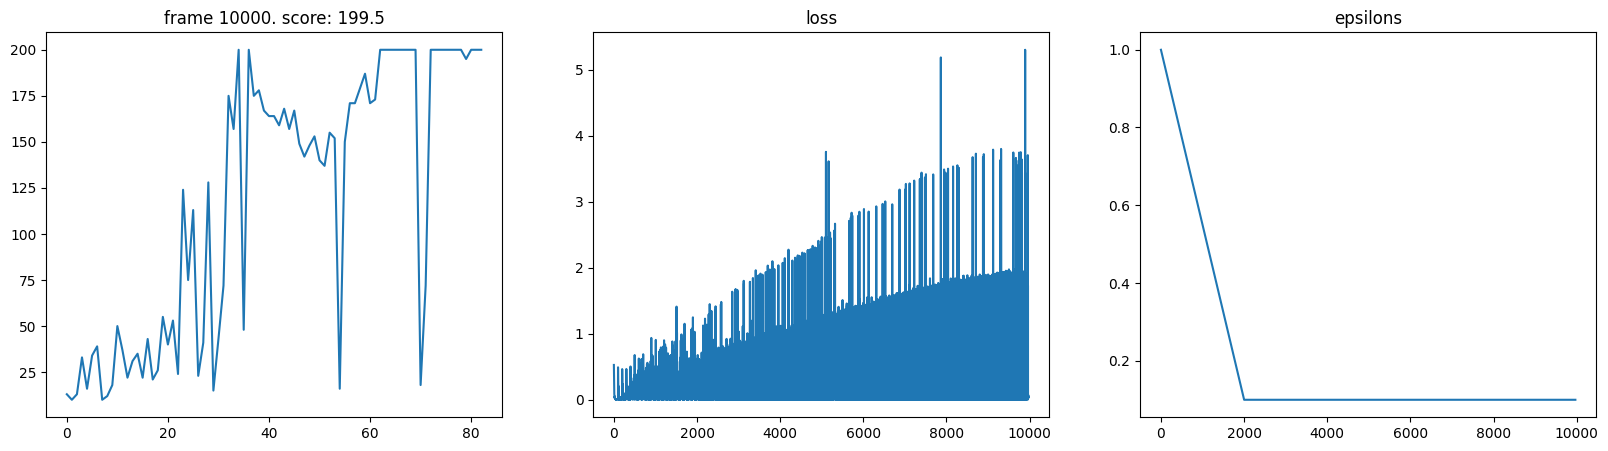

In [9]:
agent.train(num_frames)


## Test

Run the trained agent (1 episode).

In [10]:
video_folder = "videos/dqn"
agent.test(video_folder=video_folder)


Moviepy - Building video /home/tk/repos/explicit-memory-private/RoomEnv-v1/videos/dqn/rl-video-episode-0.mp4.
Moviepy - Writing video /home/tk/repos/explicit-memory-private/RoomEnv-v1/videos/dqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/tk/repos/explicit-memory-private/RoomEnv-v1/videos/dqn/rl-video-episode-0.mp4
score:  154.0


## Render

In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)


Played: videos/dqn/rl-video-episode-0.mp4
